In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_path = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import os
from skimage import io, exposure ,color #Convert the image to grayscale using `color.rgb2gray`
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss
from sklearn.preprocessing import LabelEncoder
import cv2 # : Imports OpenCV for image processing tasks.
import seaborn as sns  # Import seaborn for better visualization
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



In [4]:
def extract_hog_features(img):
    
    gry_image = color.rgb2gray(img)
    
    hog_feature, hog_img = hog(gry_image,visualize=True)
    
    hog_img_rescaled = exposure.rescale_intensity(hog_img, in_range=(0,10)) # for better visualization
    
    return hog_feature , hog_img_rescaled

In [5]:
def plot_roc_curve_multi_class(y_true, y_score, classes):
    plt.figure(figsize=(8, 6))
    
    for i in range(len(classes)):
        # Roc cruve and AUC for each class
        fpr, tpr, _ = roc_curve(y_true==i,y_score[:,i])
        roc_auc = auc(fpr,tpr)
        
        plt.plot(fpr,tpr,label=f'ROC curve for class {classes[i]} (area = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], '--')  # random guessing
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) #0.5 for better vision of the curve 
    plt.xlabel('False Positive Rate\n    1-specificity     ')
    plt.ylabel('True Positive Rate\n    sensitivity    ')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()   

In [6]:
def plot_confusion_matrix(y_true,y_pred,classes):
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, cmap='Greys', fmt='g', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def plot_loss_curve_on_training_and_testing_data(model, X_train, y_train, X_test, y_test):
    
    train_loss_values = []
    test_loss_values = []
    
    # initial loss of the training
    y_train_prob = model.predict_proba(X_train)
    train_initial_loss = log_loss(y_train,y_train_prob)
    train_loss_values.append(train_initial_loss)
    
    # initial loss of the test
    y_test_prob = model.predict_proba(X_test)
    test_initial_loss = log_loss(y_train,y_train_prob)
    test_loss_values.append(test_initial_loss)
    
    for i in range(1,101):
        
        model.partial_fit(X_train,y_train)
        # support incremental learning (like SGDClassifier), which allows them to be trained on small batches of data. Instead of retraining from scratch
        
        # loss of the training
        y_train_prob = model.predict_proba(X_train)
        train_initial_loss = log_loss(y_train,y_train_prob)
        train_loss_values.append(train_initial_loss)
        
        # loss of the test
        y_test_prob = model.predict_proba(X_test)
        test_initial_loss = log_loss(y_train,y_train_prob)
        test_loss_values.append(test_initial_loss)
        
        
    # loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(0, 101), train_loss_values, label='Training Loss Curve', color='blue')
    plt.plot(range(0, 101), test_loss_values, label='Testing Loss Curve', color='red')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title('Loss Curves on Training and Testing Data')
    plt.legend()
    plt.show()

In [8]:
class_folders = [f.path for f in os.scandir(data_path) if f.is_dir()]
features_list = []
labels_list = []

Image with feature extraction from the class Uninfected


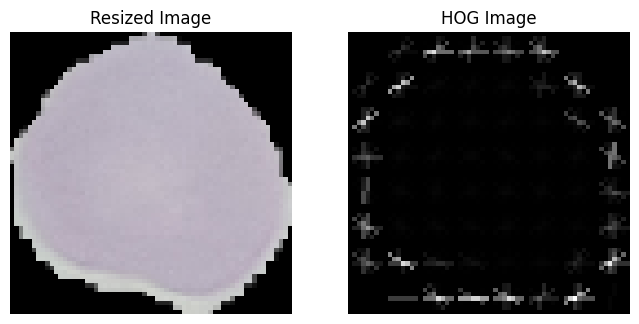

Skipping file Thumbs.db - not an acceptable image file
Image with feature extraction from the class Parasitized


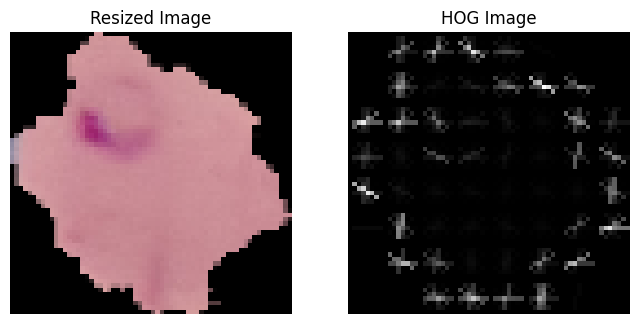

Skipping file Thumbs.db - not an acceptable image file


In [9]:
class_folders = [f.path for f in os.scandir(data_path) if f.is_dir()]
features_list = []
labels_list = []

# Define acceptable image extensions
acceptable_extensions = {'.jpg', '.jpeg', '.png'}

# Loop through each class folder
for class_folder in class_folders:
    class_name = os.path.basename(class_folder)

    # Collect all image filenames
    image_filenames = os.listdir(class_folder)

    # Loop through each image in the class folder
    for i, image_filename in enumerate(image_filenames):
        file_extension = os.path.splitext(image_filename)[1].lower()

        # Check if the file has an acceptable extension
        if file_extension not in acceptable_extensions:
            print(f"Skipping file {image_filename} - not an acceptable image file")
            continue

        image_path = os.path.join(class_folder, image_filename)

        try:
            # Load the image
            image = io.imread(image_path)

            # Resize the image to 64x64
            resized_image = cv2.resize(image, (64, 64))

            # Extract HOG features and visualize
            hog_features, hog_image = extract_hog_features(resized_image)

            if i == 0:
                print(f"Image with feature extraction from the class {class_name}")

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

                ax1.axis('off')
                ax1.imshow(resized_image, cmap=plt.cm.gray)
                ax1.set_title('Resized Image')

                ax2.axis('off')
                ax2.imshow(hog_image, cmap=plt.cm.gray)
                ax2.set_title('HOG Image')

                plt.show()

            features_list.append(hog_features)
            labels_list.append(class_name)

        except Exception as e:
            print(f"Error processing file {image_filename}: {e}")
            continue

In [10]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)

In [11]:
# Use LabelEncoder to convert class names into numeric labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels_array)

In [12]:
# Shuffle the data
features_array, numeric_labels = shuffle(features_array, numeric_labels, random_state=54)

In [13]:
#pipeline
alpha_value = 0.01  # Adjust this value as needed
model_pipeline = make_pipeline(
    StandardScaler(), 
    SGDClassifier(loss='log_loss', alpha=alpha_value, max_iter=1000, random_state=42)
)

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_array, numeric_labels, test_size=0.2, random_state=42)

In [15]:
# Fit the model on the training data using the pipeline (with scaling)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.01, loss='log_loss', random_state=42))])

In [16]:
# Calculate predicted probabilities for each class separately
y_prob_hog = model_pipeline.predict_proba(X_test)

In [17]:
# Make predictions on the test set
y_pred_hog = model_pipeline.predict(X_test)

In [18]:
accuracy_hog = accuracy_score(y_test, y_pred_hog)
print(f"Accuracy for HOG: {accuracy_hog}")

Accuracy for HOG: 0.8684687953555879


In [19]:
print("Classification Report for HOG:")
print(classification_report(y_test, y_pred_hog, target_names=label_encoder.classes_))

Classification Report for HOG:
              precision    recall  f1-score   support

 Parasitized       0.87      0.86      0.87      2733
  Uninfected       0.86      0.88      0.87      2779

    accuracy                           0.87      5512
   macro avg       0.87      0.87      0.87      5512
weighted avg       0.87      0.87      0.87      5512



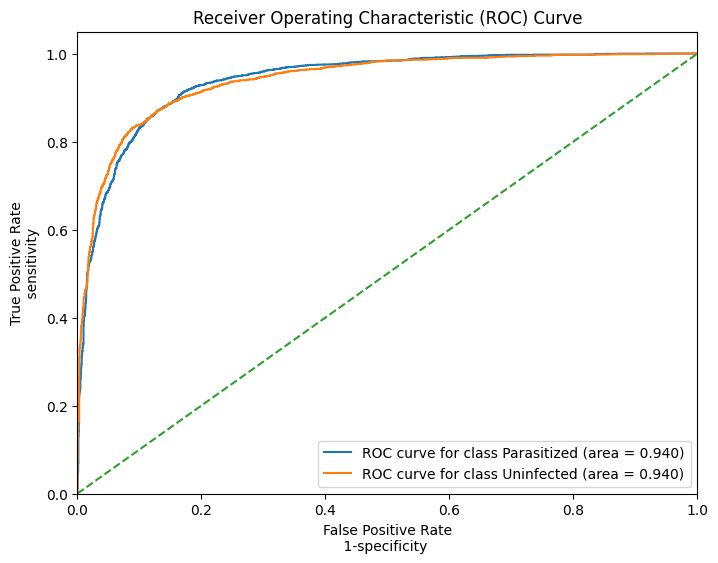

In [20]:
plot_roc_curve_multi_class(y_test, y_prob_hog, classes=label_encoder.classes_)

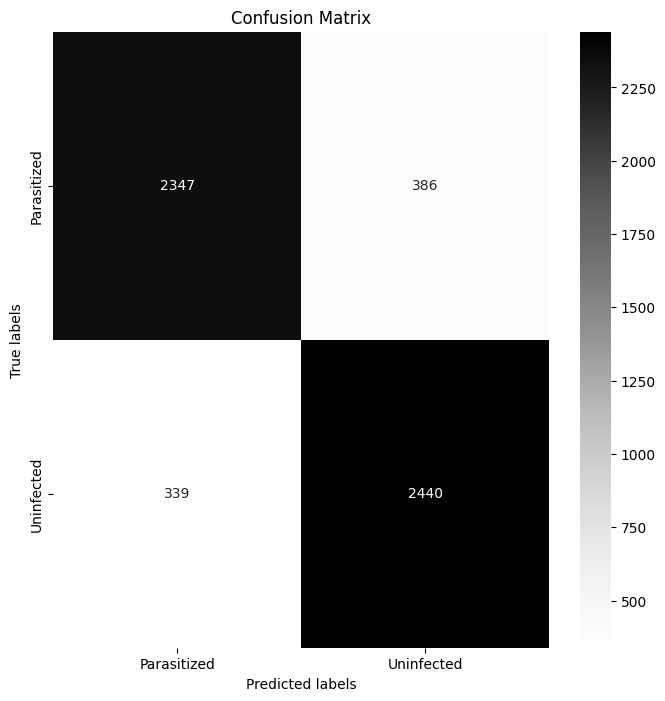

In [21]:
plot_confusion_matrix(y_test, y_pred_hog, classes=label_encoder.classes_)

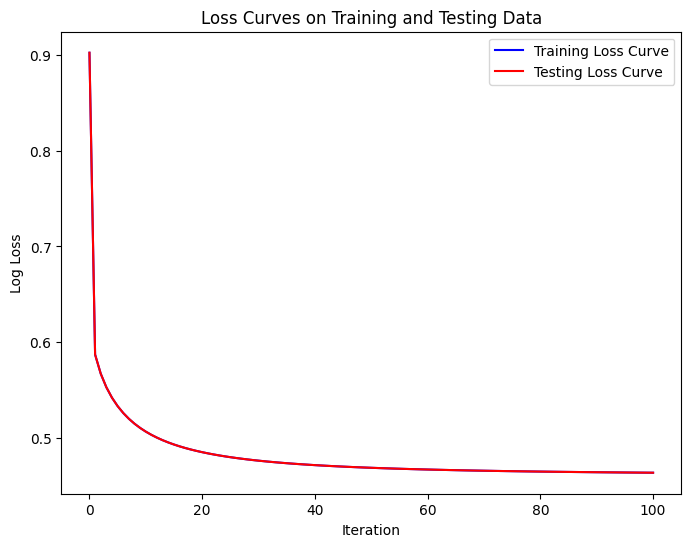

In [22]:
plot_loss_curve_on_training_and_testing_data(model_pipeline.named_steps['sgdclassifier'], X_train, y_train, X_test, y_test)

In [ ]:
# Modified SVC model with probability=True
from sklearn.svm import SVC
model_svc = SVC(C=70782, gamma=0.000977, probability=True)
model_svc.fit(X_train, y_train)

In [ ]:
import joblib
from IPython.display import FileLink, display

# Define your model and PCA saving function
def save_models():
    joblib.dump(model_svc, '/kaggle/working/malaria_svc_model-H.joblib')
    joblib.dump(pca_full_variance, '/kaggle/working/malaria_pca-H.joblib')

# Call the function to save the models
save_models()

# Display download links for each saved model
display(FileLink('/kaggle/working/malaria_svc_model-H.joblib'))
display(FileLink('/kaggle/working/malaria_pca-H.joblib'))

In [ ]:
pred = model_svc.predict(X_test)
accuracy_score(y_test, pred)
plot_confusion_matrix(model_svc, X_test, y_test,
                     cmap=plt.cm.Blues,
                                 normalize='true')
plt.show();